In [21]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from types import *
import matplotlib.animation as animation
from matplotlib import rc
import pandas as pd

In [22]:
rc('animation', html='jshtml')
figSize=600

# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, W, pars=None):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars=pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, W, pars, di, ti):
    W = W(x, t, pars=pars)
    W0 = np.sum(W)
    r = np.random.rand()
    i = 0
    W_sum = W[0]
    while W_sum / W0 < r:
        i += 1
        W_sum += W[i]
    return i

def gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = np.array(x0)
    S = np.array(S)
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:

        # Compute the time of the next reaction
        tau = next_time(x, t, W, pars, di, ti)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, W, pars, di, ti)
        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x
    
def dxdt(x, t, pars, di, ti):
    x = np.atleast_2d(x).T
    y = (S @ W(x, t, pars, di, ti)).flatten()
    return y


def solve(S, W, x0, t, pars, di, ti, model='ODE', ntraj=1):

    if model == 'ODE':
        trajectory = odeint(dxdt,np.array(x0),t, args=(pars, di, ti))

    if model == 'SSA':
        trajectory = np.zeros([ntraj, len(t), len(x0)])
        t0 = t[0]
        tmax = t[-1]
        for i in range(ntraj):
            times,states = gillespie_drugs(x0, t0, tmax, S, W, pars, di, ti, returnFullTraj=True)
            
            k = 0
            for j in range(len(times)):
                while times[j] > t[k]:
                    trajectory[i,k,:] = states[j]
                    k+=1

        trajectory = np.mean(trajectory, axis=0)
    return trajectory


def compare_model_to_data(pars,di,ti, x0, drug_number, speciesDict, drug_conc=1000, path='.', model='ODE', ntraj=10):
    #
    # example_df = pd.read_csv(r'C:\Users\wsraymon\Desktop\uqbio2024_challenge_solns\Data\Drug1_3000nM_DesignResults.csv')
    if drug_number == 0:
        example_df = pd.read_csv(path + '/NoDrug_DesignResults.csv' )
    else:
        example_df = pd.read_csv(path + '/Drug%i_%inM_DesignResults.csv'%(drug_number,drug_conc) )
    t = np.unique(example_df['Time'])
    t_app = example_df['drug_time'].iloc[0]
    data = np.zeros([5,len(t)])
    data_std = np.zeros([5,len(t)])
    k = 0
    for tp in t:
        subdf = example_df[example_df['Time'] == tp]
        subdf = subdf[subdf['is_cell_vital'] == 1]
        data[1,k] = np.mean(subdf['num_rna_nascent'])
        data[2,k] = np.mean(subdf['num_rna_nuc'])
        data[3,k] = np.mean(subdf['num_rna_cyto'])
        data[4,k] = np.mean(subdf['Cyto_Intensity_1'])

        data_std[1,k] = np.std(subdf['num_rna_nascent'])/np.sqrt(len(subdf['num_rna_nascent']))
        data_std[2,k] = np.std(subdf['num_rna_nuc'])/np.sqrt(len(subdf['num_rna_nuc']))
        data_std[3,k] = np.std(subdf['num_rna_cyto'])/np.sqrt(len(subdf['num_rna_cyto']))
        data_std[4,k] = np.std(subdf['Cyto_Intensity_1'])/np.sqrt(len(subdf['Cyto_Intensity_1']))
        k+=1

    fig,ax = plt.subplots(1,4, tight_layout=True, figsize=(10,4))
    ax[0].errorbar(t, data[1], yerr=data_std[1])
    ax[1].errorbar(t, data[2], yerr=data_std[2])
    ax[2].errorbar(t, data[3], yerr=data_std[3])
    ax[3].errorbar(t, data[4], yerr=data_std[4])

    ax[0].plot([t_app, t_app], [0, max(data[1])], 'r--', label='_nolegend_')
    ax[1].plot([t_app, t_app], [0, max(data[2])], 'r--', label='_nolegend_')
    ax[2].plot([t_app, t_app], [0, max(data[3])], 'r--', label='_nolegend_')
    ax[3].plot([t_app, t_app], [0, max(data[4])], 'r--', label='_nolegend_')

    ax[0].set_title('Nascent RNA')
    ax[1].set_title('Nuclear RNA')
    ax[2].set_title('Cytosolic RNA')
    ax[3].set_title('Protein (intensity)')

    s = solve(S, W, x0, np.linspace(0,2000,2001),pars, di, ti, model=model, ntraj=ntraj )

    ax[0].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nascent']], )
    ax[1].plot(np.linspace(0,2000,2001), s.T[speciesDict['Nuclear']],)
    ax[2].plot(np.linspace(0,2000,2001), s.T[speciesDict['Cytoplasmic']],)
    ax[3].plot(np.linspace(0,2000,2001), s.T[speciesDict['Protein']],)

    ax[0].set_xlim([1000,2000])
    ax[1].set_xlim([1000,2000])
    ax[2].set_xlim([1000,2000])
    ax[3].set_xlim([1000,2000])

In [23]:
#model variables

#x1 = gene (DNA) ON
#x2 = gene (DNA) OFF
#x3 = nascent mRNA
#x4 = mature mRNA nuclei
#x5 = mature mRNA cytoplasm
#x6 = protein

#Reactions
#R1 = Gene Activation
#R2 = Gene deactivation
#R3 = Gene Transcription  --> drug
#R4 = nascent mRNA maturation
#R5 = mature mRNA Nuclear Export
#R6 = mature mRNA Nuclear degradation
#R7 = mature mRNA Cytoplasmic degradation
#R8 = mature mRNA Cytoplasmic Translation
#R9 = protein Degradation

K = 1000
n = 3

# Hill functions
def hillPositive(x, K=K, n=n):
    return x**n / (K**n + x**n)

def hillNegative(x, K=K, n=n):
    return K**n / (K**n + x**n)

#initial conditions
x1 = 1
x2 = 0
x3 = 4 #??
x4 = 5
x5 = 8
x6 = 760

k1 = 0.1
k2 = 0.1
k3 = 0.1
k4 = 0.1
k5 = 0.1
k6 = 0.1
k7 = 0.1
k8 = 0.1
k9 = 0.1

S1 = np.array([1,-1,0,0,0,0])  #R1 = Gene Activation
S2 = np.array([-1,1,0,0,0,0])  #R2 = Gene Deactivation
S3 = np.array([0,0,1,0,0,0])   #R3 = Gene Transcription  --> drug
S4 = np.array([0,0,-1,1,0,0])  #R4 = nascent mRNA maturation
S5 = np.array([0,0,0,-1,1,0])  #R5 = mature mRNA Nuclear Export
S6 = np.array([0,0,0,-1,0,0])  #R6 = mature mRNA Nuclear degradation
S7 = np.array([0,0,0,0,-1,0])  #R7 = mature mRNA Cytoplasmic degradation
S8 = np.array([0,0,0,0,0,1])   #R8 = mature mRNA Cytoplasmic Translation
S9 = np.array([0,0,0,0,0,-1])  #R9 = protein Degradation


r1 = k1*x1 - k2*x2
r2 = k2*x2 - k1*x1
r3 = k3*x1
r4 = -k4*x3 + k4*x4
r5 = -k5*x3
r6 = -k6*x4
r7 = k7*x4
r8 = -k8*x5

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 6)

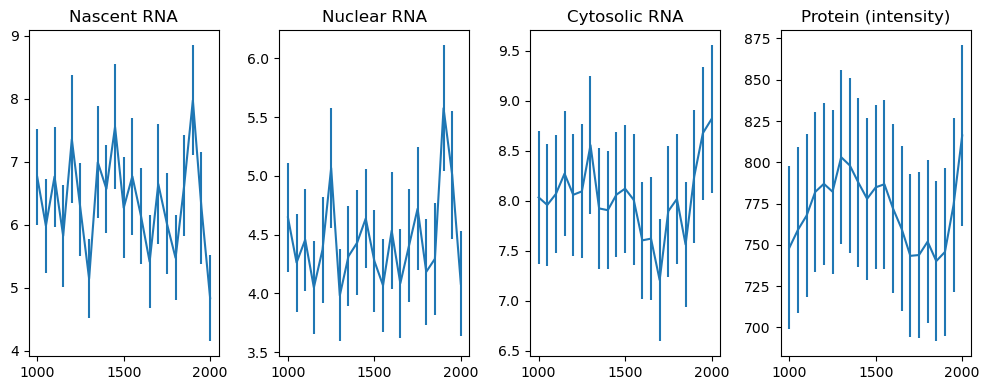

In [24]:
#stechiometry matrix
S = np.array([
    [1, -1, 0, 0, 0, 0, 0, 0, 0],   # R1: Gene Activation
    [-1, 1, 0, 0, 0, 0, 0, 0, 0],   # R2: Gene Deactivation
    [0, 0, 1, 0, 0, 0, 0, 0, 0],    # R3: Gene Transcription
    [0, 0, -1, 1, 0, 0, 0, 0, 0],   # R4: nascent mRNA maturation
    [0, 0, 0, -1, 1, 0, 0, 0, 0],   # R5: mature mRNA Nuclear Export
    [0, 0, 0, -1, 0, 0, 0, 0, 0],   # R6: mature mRNA Nuclear degradation
    [0, 0, 0, 0, -1, 0, 0, 0, 0],   # R7: mature mRNA Cytoplasmic degradation
    [0, 0, 0, 0, 0, 1, 0, 0, 0],    # R8: mature mRNA Cytoplasmic Translation
    [0, 0, 0, 0, 0, 0, 0, 0, -1]    # R9: protein Degradation
])


di = [0,1000,0] #drug concentration
ti = [np.inf,1200,np.inf] #time of drug addition

x0 = np.array([x3,x4,x5,x6]) #beginning state

pars = [10,0.3,0.5,0.2,0.4,0.6,0.7,0.8,0.01] #k1,k2,k3,k4,k5,k6,k7,k8,k9

speciesDict = {
    'Nascent': 2,
    'Nuclear': 3,
    'Cytoplasmic': 4,
    'Protein': 5
}

def W(x, t, pars, di, ti):
    W = [pars[0] + pars[4]*di[1]*(t>ti[1]),  # Note -- you may want to add Hill Functions here
        pars[1] + pars[5]*(t>ti[1]),
        pars[2] + pars[6]*(t>ti[1]),
        pars[3] + pars[7]*(t>ti[1])]
    return np.array(W)

pathName = "TrueData"
drug_number = 0 # use 0 for no drug!
compare_model_to_data(pars, di, ti, x0, drug_number, speciesDict, drug_conc=1000, path=pathName,
                    model='ODE',ntraj=10)